In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# 🏠 The First Exploration of MLPs 🏠

Welcome to the first exploration of **Multi-Layer Perceptrons (MLPs)**! 

We are working with **housing data** where each house has the following features:
- **in_sf**: 🌉 Whether the house is in San Francisco (SF) or not
- **beds**: 🛏 Number of bedrooms
- **bath**: 🛁 Number of bathrooms
- **price**: 💲 Price of the house
- **year_built**: 🏗 Year the house was built
- **sqft**: 📏 Square footage of the house
- **price_per_sqft**: 💰 Price per square foot
- **elevation**: 🌄 Elevation of the house

This is a **binary classification problem** where each house is either in **San Francisco (SF)** or **New York City (NYC)**.

<small>Data credits:</small>

<span style="font-size: smaller;"> This dataset was collected for A Visual Introduction to Machine Learning (http://www.r2d3.us). It is available under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-nc-sa/4.0/).  We hope it helps you practice different data analysis and visualization techniques. ONE REQUEST: Please do not use this data to make any conclusions about the New York or San Francisco real estate markets. This data was collected with learning, not inference, in mind. :-) </span>



In [4]:
with open('../data/sf_vs_nyc_house_data.csv', 'r') as f:
    labels = f.readline()

print(labels)

full_data = np.genfromtxt('../data/sf_vs_nyc_house_data.csv', delimiter=',')[1:]
full_data.shape

in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation



(492, 8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(full_data[:,1:], full_data[:,:1], test_size=.2, random_state=34)

print(f' Train shape X: {X_train.shape} y: {y_test.shape} \n  Test shape X: {X_test.shape}  y: {y_test.shape} ')

 Train shape X: (393, 7) y: (99, 1) 
  Test shape X: (99, 7)  y: (99, 1) 


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(7,5)
        self.relu0 = nn.ReLU()
        self.l1 = nn.Linear(5,3)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(3,1)
        self.out = nn.Sigmoid()

    def forward(self,X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        logits = self.l2(x)
        x = self.out(logits)
        return x
    
model = MLP()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
        

In [ ]:
#getting the small sub set
X_sub = torch.tensor(X_train[:10], dtype=torch.float32)
y_sub = torch.tensor(y_train[:10], dtype=torch.float32)
y_sub

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

We got a little bit from both classes so lets see if we can learn

<style>
hr {
  border: none;
  border-top: 10px solid pink;
}
</style>

---


Can we over fit the data?
Lets use this small sub set and over fit baby!!

100%|██████████| 10000/10000 [00:01<00:00, 6689.68it/s]


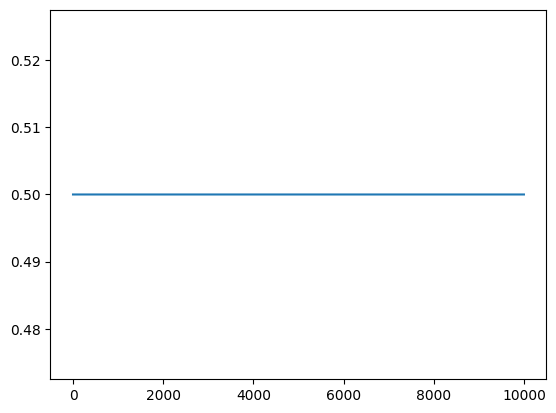

In [ ]:
lossi = []

model.train()
for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    y_pred = model(X_sub)

    optimizer.zero_grad()

    loss = criterion(y_pred, y_sub)
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()
    

plt.plot(lossi)

In [ ]:
y_pred

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)

## WE Suck
### We are Stuck at loss of ```0.500000``` seems SGD can't learn this can we do better with Adam and Binary Cross Entropy?

<style>
hr {
  border: none;
  border-top: 10px solid pink;
}
</style>

---

**Adam Optimizer**: Better than SGD: Faster convergence, handles sparse gradients better. Helps us avoid getting stuck in flat areas (plateaus) during training, ensuring smoother progress.


**Binary Cross-Entropy Loss**: A more effective choice than Mean Squared Error (MSE) for binary classification problems (where we predict 0 or 1). We'll explore why MSE isn't ideal soon! 


100%|██████████| 10000/10000 [00:02<00:00, 4712.30it/s]


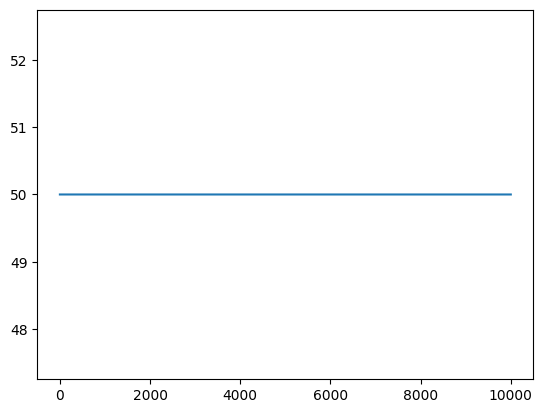

In [ ]:
class MLP_Adam(nn.Module):
    def __init__(self):
        super(MLP_Adam, self).__init__()
        self.l0 = nn.Linear(7,5)
        self.relu0 = nn.ReLU()
        self.l1 = nn.Linear(5,3)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(3,1)
        self.out = nn.Sigmoid()

    def forward(self,X):
        x = self.l0(X)
        x = self.relu0(x)
        x = self.l1(x)
        x = self.relu1(x)
        logits = self.l2(x)
        x = self.out(logits)
        return x, logits
    
model_a = MLP_Adam()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_a.parameters(), lr=0.0003)

lossi = []

for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    y_pred = model_a(X_sub)

    loss = criterion(y_pred[0], y_sub)
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()

plt.plot(lossi)

In [ ]:
lossi[-1]

50.0

### Ok so our good friend Mr. Adam is not doing too well ether. Lets think aout whats going on! 🤔

<style>
hr {
  border: none;
  border-top: 10px solid pink;
}
</style>

---

So, we are now learning and we know that **Adam** can help us avoid getting stuck at plateaus. We also know that **Cross Entropy Loss** is better than **Mean Squared Error (MSE)** for binary classification problems. We will look at why MSE is less effective for binary classification in a bit. Since we know that **Adam** and **BCELoss** are good choices, let's take a look at the weights🏋️ and pred **ŷ** of the neural network and see what's going on. 

In [ ]:
y_pred = model_a(X_sub)
y_pred[0]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SigmoidBackward0>)

So it's all ones🤨 

Lets look at the logits in the nn. (the numbers before going to the sigmoid **σ** sqishification function) 

We defined the MLP adam as such  so that we can get the logits too

```
    def forward(self,X):
        .......
        logits = self.l2(x)
        x = self.out(logits)
        return x, logits
```

In [ ]:
y_pred[1] #these are the logits from the tuple

tensor([[-115058.1875],
        [-160668.1719],
        [-105025.9141],
        [ -94719.7344],
        [-338353.4688],
        [ -87934.3438],
        [-213563.5469],
        [-264447.2500],
        [-661176.0000],
        [ -81157.4219]], grad_fn=<AddmmBackward0>)

### So these logits are huge 🐘🐘 like WTF huge. Large forward activations can cause problems but to see why lets take the network apart

In [ ]:
#new model initialization
model_a = MLP_Adam()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_a.parameters(), lr=0.0003)

In [ ]:
model_a.l1.weight

Parameter containing:
tensor([[-0.1333, -0.2228, -0.0382, -0.0707,  0.0236],
        [ 0.3473,  0.1686,  0.0399, -0.2791,  0.0666],
        [ 0.1704, -0.1552,  0.4088, -0.1714,  0.3172]], requires_grad=True)

So relatively small weights as you expect for a good nn initialiation

In [ ]:
y_pred = model_a(X_sub)
print(y_pred[0])
print(y_pred[1])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)
tensor([[ 40806.4453],
        [ 56930.7266],
        [ 37222.3359],
        [ 33649.8320],
        [119926.2969],
        [ 31170.8770],
        [ 75692.4766],
        [ 93700.5547],
        [234257.0625],
        [ 28749.1484]], grad_fn=<AddmmBackward0>)


The true lables are as such:
```
tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
```



### Now lets take a look at the loss:

In [ ]:
loss = criterion(y_pred[0], y_sub)
loss

tensor(50., grad_fn=<BinaryCrossEntropyBackward0>)

50 seems a little odd but we know that Binary Cross Entropy is:

<br>

J(θ) = -1/m * Σ log(corrected_probability)

<br>
<br>
<br>


If the pred label is wrong then the corrected label is (1 - pred_label)

| True Labels | Pred Labels | Correct Labels | Log(Correct Labels) |
|--------------|--------------|-----------------|----------------------|
| [1.]         | 0           | 1               | 0                   |
| [0.]         | 0           | 0               | -100                |
| [1.]         | 0           | 1               | 0                   |
| [1.]         | 0           | 1               | 0                   |
| [1.]         | 0           | 1               | 0                   |
| [0.]         | 0           | 0               | -100                |
| [0.]         | 0           | 0               | -100                |
| [0.]         | 0           | 0               | -100                |
| [0.]         | 0           | 0               | -100                |
| [1.]         | 0           | 1               | 0                   |

*note that in pytorch for log(0) they just set it to -100

<br>
<br>

So now we sum: -1/10 * (0 + -100 + 0 + 0 + 0 + -100 + -100 + -100 + -100 + 0) = 50
So thats how we get the loss of 50!! 💡
<br>

Now that we know where the 50 comes from we now need to figure out the real problem of why we are not learning 😔
<br>
<br>

### Now lets look at the gradients:

In [ ]:
optimizer.zero_grad()
loss.backward()

In [ ]:
print(model_a.l0.weight.grad,'\n')
print(model_a.l1.weight.grad,'\n')
print(model_a.l2.weight.grad,'\n')

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]) 

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]) 

tensor([[0., 0., 0.]]) 



Well no wonder we are not learning since the grad's are all zero we are not updating a single damn weight. 😑 BRUHH whats going on ¿?¿?
<br>
</br>

Lets think 💭💭...........

The issue is in the derivatives. The of sigmoid derivative is **∂σ/∂x  = σ(x) * 1 - σ(x)**

but since sigmoid is the activation of our last layer then **σ(x) = output** or **σ(x) = ŷ**

ok... ok..

Now we also remember that the forward activations are HUGE or -HUGE.

Now we also know that σ(x) = 1 for large x and σ(x) = 0 for large -x

This leads us to realize that:

**our ŷ is always [0...0] or [1...1]**

<br>
</br>


Now, if we try to take the derivative, we end up with one of these two scenarios:

1. **Scenario 1:**
   $$
   \sigma(x) \cdot (1 - \sigma(x)) = [0, 0, \ldots, 0] \cdot \text{something} = 0
   $$

2. **Scenario 2:**
   $$
   \sigma(x) \cdot (1 - \sigma(x)) = [1, 1, \ldots, 1] \cdot [0, 0, \ldots, 0] = 0
   $$



##  EUREKA!! 

🚨 We have the issue of our inputs being **HUGE** because we forgot to normalize them. 🚨

Let's **normalize** them to see if that fixes the problem. 🛠️


In [ ]:
#Normalize time
X = torch.tensor(full_data[:,1:], dtype=torch.float32)  # 492 samples, each with 7 features

X_norm= torch.nn.functional.normalize(X, dim=0) #normalize across columns 

y_norm = torch.tensor(full_data[:,:1], dtype=torch.float32) 
torch.bincount((y.to(torch.int64)).squeeze())

tensor([224, 268])

Lets use not all the data and see if we can first memorize 11 samples

In [ ]:
X_norm_sub = X_norm[::48]
y_norm_sub = y_norm[::48]
X_norm_sub.shape

torch.Size([11, 7])

In [ ]:
#new model initialization
model_a = MLP_Adam()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_a.parameters(), lr=0.001)

100%|██████████| 10000/10000 [00:02<00:00, 4669.88it/s]


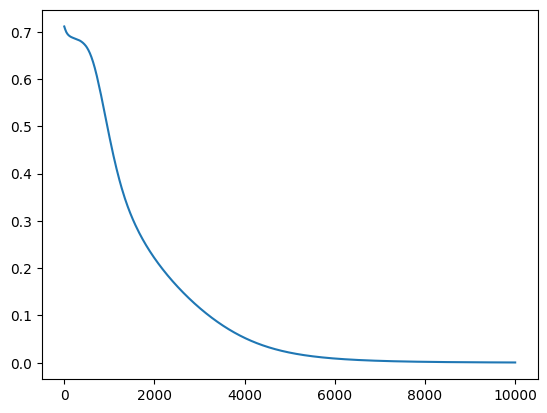

In [ ]:
lossi = []

for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    y_pred = model_a(X_norm_sub)

    loss = criterion(y_pred[0], y_norm_sub)
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()

plt.plot(lossi)

Accuracy on training data: 0.5041


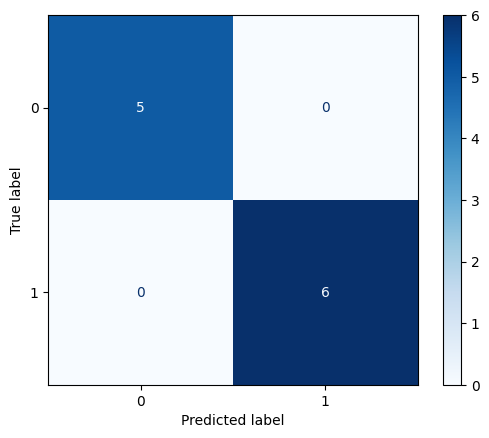

In [ ]:
model_a.eval()
with torch.no_grad():
    predictions = model_a(X_norm_sub)[0].squeeze()
    predictions = (predictions >= 0.2).float()  # Convert probabilities to binary predictions
    accuracy = (predictions == y_norm_sub).float().mean()
    print(f'Accuracy on training data: {accuracy:.4f}')

cm = confusion_matrix(y_norm_sub.numpy(), predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 🎉 **EUREKA!!** 🎉

We did is we over fit!!!!


Now in the name of learning(our selves not the machine) lets see if this will solve our issue to:

ReLU looks like this:

* **f(x) = max(0, x)**

so the large inputs were being passed along through the activation fucntions.

but what if we used tanh insted of ReLU

The hyperbolic tangent (tanh) activation function is defined as:

$$
    f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$


### So lets give it a go!


100%|██████████| 600/600 [00:00<00:00, 4226.86it/s]


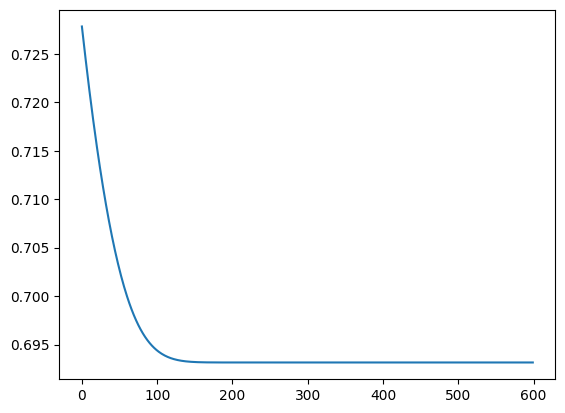

In [ ]:
class MLP_Tanh(nn.Module):
    def __init__(self):
        super(MLP_Tanh, self).__init__()
        self.l0 = nn.Linear(7,5)
        self.tanh0 = nn.Tanh()
        self.l1 = nn.Linear(5,3)
        self.tanh1 = nn.Tanh()
        self.l2 = nn.Linear(3,1)
        self.out = nn.Sigmoid()

    #we save the res to later return and see the res of the forward pass at each layer
    def forward(self,X):
        res = []
        x = self.l0(X)
        res.append(x)
        x = self.tanh0(x)
        res.append(x)
        x = self.l1(x)
        res.append(x)
        x = self.tanh1(x)
        res.append(x)
        logits = self.l2(x)
        res.append(logits)
        x = self.out(logits)
        res.append(x)
        return x, logits, res
    
    
model_tanh = MLP_Tanh()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_tanh.parameters(), lr=0.001)


lossi = []

for epoch in tqdm(range(600)):
    optimizer.zero_grad()
    y_pred = model_tanh(X_sub)

    loss = criterion(y_pred[0], y_sub)
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()

plt.plot(lossi)

Well damn 😔 tanh did not work lets go under the hood and take a look 👀

### Our forward pass returns the y_hat(pred) the logits(value pre last activaion) and the list of all the results of each layer and ac(activation function)

In [ ]:
#reinitialzie to see the first foward pass res
model_tanh = MLP_Tanh()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_tanh.parameters(), lr=0.001)

In [ ]:
y_hat, logits, all_forwad_activations = model_tanh.forward(X_sub)

In [ ]:
y_hat

tensor([[0.6289],
        [0.6289],
        [0.6289],
        [0.6289],
        [0.6289],
        [0.6289],
        [0.6289],
        [0.6289],
        [0.6289],
        [0.6289]], grad_fn=<SigmoidBackward0>)

The y_hat looks bad as we would expect
<br>
</br>

### Now lets take a look at the res from the first layer of neuron pre tanh funtion

In [ ]:
all_forwad_activations[0]

tensor([[ -194323.6875,    24952.6973,  -275140.8438,   -30912.5449,
            84261.1250],
        [ -271261.1250,    35376.7969,  -383668.5625,   -43051.3750,
           117714.4062],
        [ -177232.3281,    22803.4980,  -251034.3750,   -28262.8105,
            76901.5078],
        [ -160167.3906,    20183.8223,  -226858.6250,   -25544.2656,
            69355.0391],
        [ -571850.6875,    75243.9219,  -807820.9375,   -90171.5078,
           248057.2344],
        [ -148378.5781,    18973.2285,  -210275.6250,   -23706.8848,
            64373.2812],
        [ -360782.3438,    47204.7500,  -509991.0312,   -57080.6836,
           156517.2969],
        [ -446700.5312,    58746.6367,  -631230.0000,   -70595.4609,
           193834.6562],
        [-1117447.3750,   148188.3906, -1577762.0000,  -175740.0938,
           484860.7188],
        [ -136844.7812,    17516.7031,  -193985.6406,   -21934.8906,
            59410.1992]], grad_fn=<AddmmBackward0>)

Uhh Ohh those are big 😯


Lets look at the distribution

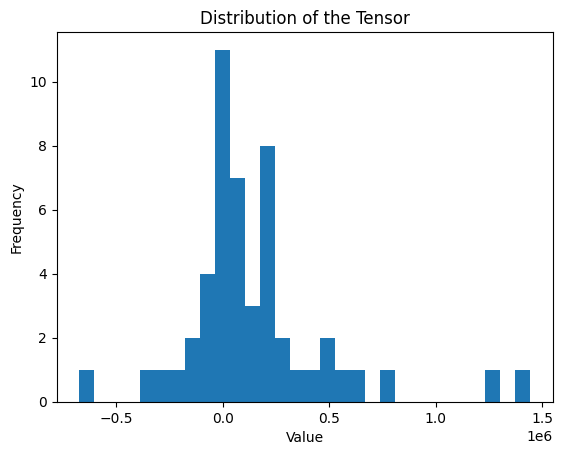

In [ ]:
plt.hist(all_forwad_activations[0].detach().numpy().flatten(), bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of the Tensor')
plt.show()

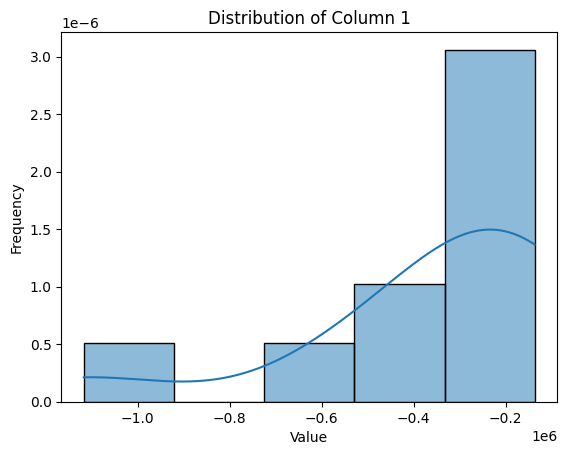

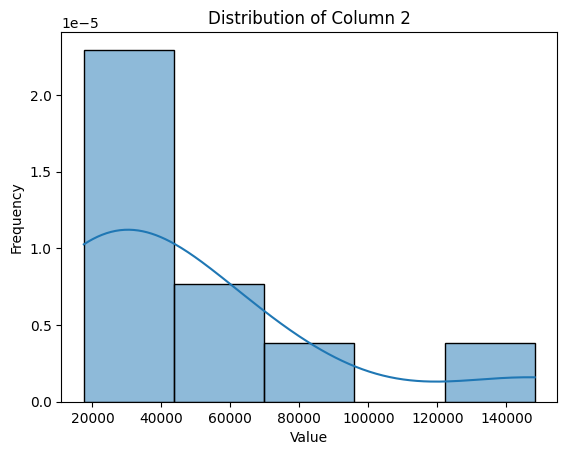

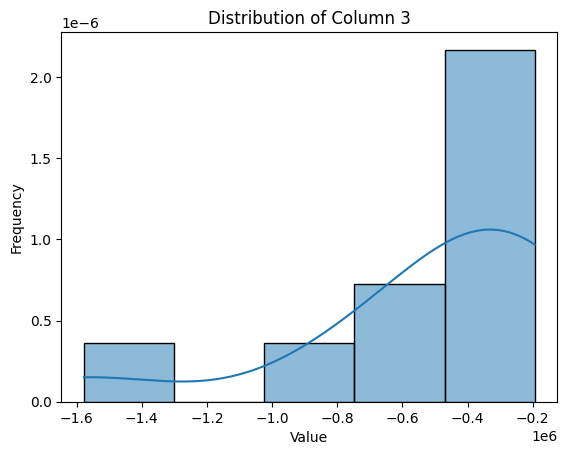

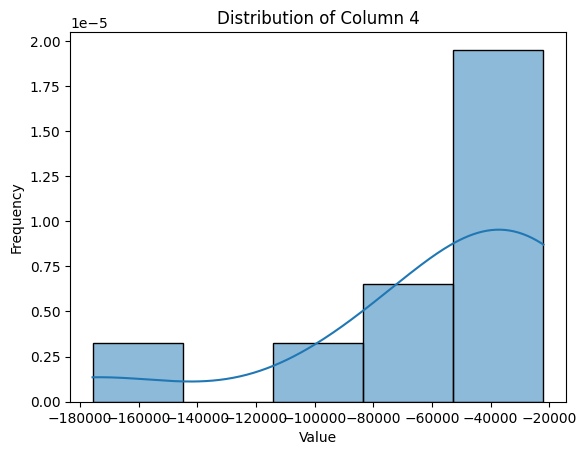

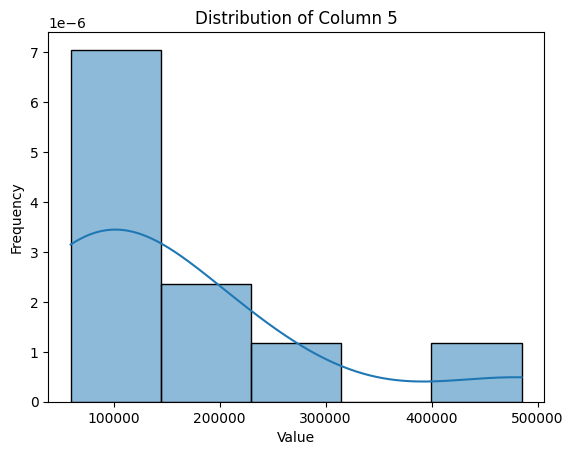

In [ ]:
tensor_array = all_forwad_activations[0].detach().numpy()

# Get the number of columns in the tensor
num_cols = tensor_array.shape[1]

# Plot a histogram for each column
for i in range(num_cols):
    #plt.hist(tensor_array[:, i], bins=30)
    sns.histplot(tensor_array[:, i], kde=True, stat='density')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Column {i+1}')
    #plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    plt.show()

So these are very big valuse and we know thats never🚫🚫 a good thing in nn but lets take a look at the out put of the next layer which is the res after tanh 👀

In [ ]:
all_forwad_activations[1]

tensor([[ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.,  1.]], grad_fn=<TanhBackward0>)

Well i'll be damned they are all the same. So now we can't learn because they are all the exact same values for each sample

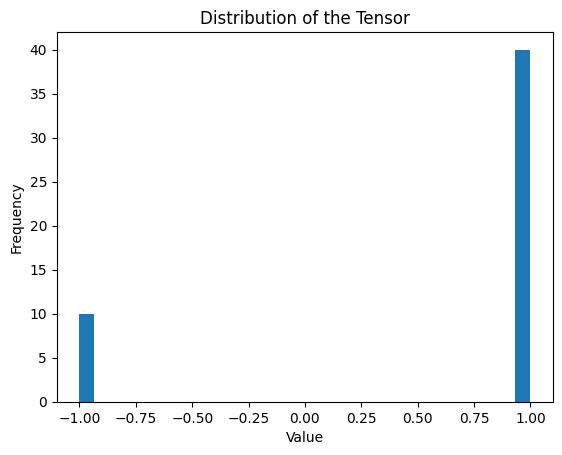

In [ ]:
plt.hist(all_forwad_activations[1].detach().numpy().flatten(), bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of the Tensor')
plt.show()

# 🚀 The End of a Wild Ride! 🚀

What a wild ride it has been! 

As in "The Accountant" (2016), Christian Wolff said: 
> "What if ..., you became obsessed with how to normalize the chaos?"

While he might not be talking about the normalization we did, he is spot on! We need to normalize our inputs, or our neural network will go all out of whack!
